### The K-Armed Bandit

The k-armed bandit problem is a simple reinforcement learning problem where the environment contains only a single state. The agent is presented with k different actions that it can take, and each action gives out a reward generated from some stationary probability distribution. The agent starts out not knowing which action is the best action, so it must first explore all of the possibilities to figure out the expected reward of each action.

The real-life analogy of this problem is a gambler (bandit) that wants to maximize their money (reward) by playing the slot machines, but there are k slot machines, each with its own probabilistic payoff. The gambler must then figure out which slot machine is the most profitable.

In [2]:
# Setup

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

def reset_seed(seed=42):
    np.random.seed(seed)

### The Environment

There will be two kinds of environments: discrete and continuous. A discrete bandit environment just means that there are some finite number of payoffs, each with its own probability (total probability must add up to one). A continuous bandit environment generates payoffs based on some probability distribution.

In [3]:
class DiscreteBandit():
    """
    A discrete bandit environment.
    
    Args:
        payoffs: (ndarray of shape [n_arms, n_payoffs]) the payoffs for each action
        probabilities: (ndarray of shape [n_arms, n_payoffs]) the probability for every payoff of every action
    """
    def __init__(self, payoffs, probabilities):
        self.payoffs = payoffs
        self.probabilities = probabilities
        
    def step(self, x):
        return np.random.choice(self.payoffs[x], p=self.probabilities[x])

In [4]:
reset_seed(42)

payoffs = np.array([[-1, 0, 1],
                    [-2, 0, 5],
                    [0, 4, 8],
                    [-2, -1, 1]])

probabilities = np.array([[0.45, 0.1, 0.45],
                          [0.45, 0.1, 0.45],
                          [0.98, 0.01, 0.01],
                          [0.98, 0.01, 0.01]])

env = DiscreteBandit(payoffs, probabilities)

max_steps = 1000
total_reward = 0

for step in range(max_steps):
    total_reward += env.step(np.random.choice(len(payoffs)))  # choose a random action
    
print("Total reward:", total_reward)

Total reward: -111


In [5]:
class ContinuousBandit():
    """
    A continuous bandit environment.
    
    Args:
        reward_distributions: (list of functions) a list of functions that generate random numbers from
            some probability distribution
    """
    def __init__(self, reward_distributions):
        self.reward_distributions = reward_distributions
        
    def step(self, x):
        return self.reward_distributions[x]()

In [6]:
reset_seed(42)

mu = [np.random.uniform(-10, 10) for _ in range(5)]
sigma = [np.random.uniform(0, 5) for _ in range(5)]
reward_distributions = [partial(np.random.normal, m, s) for m, s in zip(mu, sigma)]

for m, s in zip(mu, sigma):
    print("Mean: %.2f \t Sigma: %.2f" % (m, s))

env = ContinuousBandit(reward_distributions)

max_steps = 1000
total_reward = 0

for step in range(max_steps):
    total_reward += env.step(np.random.choice(len(reward_distributions)))  # choose a random action
    
print("Total reward: %.2f" % total_reward)

Mean: -2.51 	 Sigma: 0.78
Mean: 9.01 	 Sigma: 0.29
Mean: 4.64 	 Sigma: 4.33
Mean: 1.97 	 Sigma: 3.01
Mean: -6.88 	 Sigma: 3.54
Total reward: 848.69


### The Greedy Policy

Because we are interested in creating an artificial intelligence, our agent needs to do better than just taking a random action at each step. The agent needs to be able to make decisions based on something. In RL lingo, we call this decision-making ability a "policy". The simplest non-random policy is probably the greedy policy, where the agent chooses what it thinks as the optimal action at each given step.

In [7]:
reset_seed(42)

n = 5

mu = [np.random.uniform(-10, 10) for _ in range(n)]
sigma = [np.random.uniform(0, 5) for _ in range(n)]
reward_distributions = [partial(np.random.normal, m, s) for m, s in zip(mu, sigma)]

# Store rewards obtained at each step. This acts as a "memory" and can be used to make decisions.
total_rewards = [0 for _ in range(n)]
n_tries = [0 for _ in range(n)]

def expected_reward(a):
    if n_tries[a] == 0:
        return 0
    else:
        return total_rewards[a] / n_tries[a]
    
def greedy_policy():
    return np.argmax([expected_reward(a) for a in range(n)])

env = ContinuousBandit(reward_distributions)

max_steps = 1000

for step in range(max_steps):
    a = greedy_policy()
    reward = env.step(a)
    total_rewards[a] += reward
    n_tries[a] += 1
    
print("Total reward: %.2f" % sum(total_rewards))

Total reward: 9008.13


### The Exploration-Exploitation Tradeoff

The greedy policy has an obvious weakness: it is short-sighted. A typical reinforcement learning environment is full of unknowns, the agent almost always starts out not knowing which action is the best and what is the expected reward of each action. It faces the dilemma of choosing between what it thinks is the optimal action (exploitation), and choosing some other action in the hope of improving its knowledge so that it can make better decisions in the future (exploration). This is called the exploration-exploitation tradeoff.

In the greedy example above, the agent performs no exploration at all, it always chooses what it thinks as the best action at each step. As a result, it stops looking when it finds an action that yields a positive reward (on average), and doesn't consider the possibility that there might be some other action that gives better rewards. One way to integrate exploration into the greedy policy is to perform each action some number of times to gather data before going greedy all the way until the end. Since there are 1000 time steps, one option is to perform each action 20 times for the first 100 time steps, then choose the best action for the other 900. But this approach seems arbitrary, and it doesn't guarantee convergence (there's a non-zero chance that 20 data points per action isn't enough to determine the true expected reward of every action).

One exploration policy that has been around since the dawn of RL is the epsilon-greedy policy. It works by setting some exploration coefficient, epsilon, that determines the probability of choosing a random action instead of taking the greedy action. So, if epsilon is set to 0.1, then at any given time step the agent has 10% probability of choosing a random action and 90% probability of choosing the greedy action. This policy guarantees convergence, each action will be taken an infinite number of times as time goes to infinity.

In [8]:
reset_seed(42)

n = 5

mu = [np.random.uniform(-10, 10) for _ in range(n)]
sigma = [np.random.uniform(0, 5) for _ in range(n)]
reward_distributions = [partial(np.random.normal, m, s) for m, s in zip(mu, sigma)]

# Store rewards obtained at each step. This acts as a "memory" and can be used to make decisions.
total_rewards = [0 for _ in range(n)]
n_tries = [0 for _ in range(n)]

def expected_reward(a):
    if n_tries[a] == 0:
        return 0
    else:
        return total_rewards[a] / n_tries[a]
    
def epsilon_greedy(epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n)  # random action
    else:
        return np.argmax([expected_reward(a) for a in range(n)])  # greedy action

env = ContinuousBandit(reward_distributions)

max_steps = 1000
epsilon = 0.1

for step in range(max_steps):
    a = epsilon_greedy(epsilon)
    reward = env.step(a)
    total_rewards[a] += reward
    n_tries[a] += 1
    
print("Total reward: %.2f" % sum(total_rewards))

Total reward: 8036.72


### Comparing Policies

To see which policy works best for the k-armed bandit problem, we will instantiate agents with differing policies and test them on randomized k-armed bandit environments.

In [14]:
class EpsilonGreedyAgent():
    """
    A class to represent an agent using epsilon-greedy policy.
    
    Args:
        epsilon: (scalar) the epsilon constant
        n_actions: (int) the number of possible actions
    """
    def __init__(self, epsilon, n_actions):
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.reset_memory()
        
    def expected_reward(self, action):
        if self.n_tries[action] == 0:
            return 0
        else:
            return self.total_rewards[action] / self.n_tries[action]
        
    def epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax([self.expected_reward(action) for action in range(self.n_actions)])
        
    def update_memory(self, action, reward):
        self.total_rewards[action] += reward
        self.n_tries[action] += 1
        
    def reset_memory(self):
        self.total_rewards = [0 for _ in range(self.n_actions)]
        self.n_tries = [0 for _ in range(self.n_actions)]

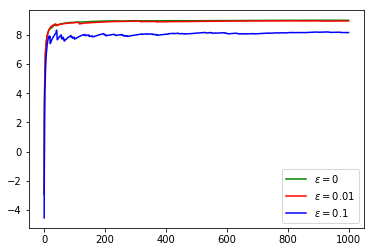

In [15]:
# A comparison run

reset_seed(42)

n = 5

mu = [np.random.uniform(-10, 10) for _ in range(n)]
sigma = [np.random.uniform(0, 5) for _ in range(n)]
reward_distributions = [partial(np.random.normal, m, s) for m, s in zip(mu, sigma)]

env = ContinuousBandit(reward_distributions)

agents = [EpsilonGreedyAgent(epsilon=0, n_actions=n),     # epsilon = 0, full greed
          EpsilonGreedyAgent(epsilon=0.01, n_actions=n),  # epsilon = 0.01, mostly greedy
          EpsilonGreedyAgent(epsilon=0.1, n_actions=n)    # epsilon = 0.1, somewhat greedy
         ]

average_rewards = [[] for _ in range(len(agents))]

max_steps = 1000

for step in range(max_steps):
    for agent_index, agent in enumerate(agents):
        action = agent.epsilon_greedy()
        reward = env.step(action)
        agent.update_memory(action, reward)
        average_rewards[agent_index].append(sum(agent.total_rewards) / (step + 1))
    
plt.plot(np.arange(max_steps), average_rewards[0], 'g-', label=r"$\epsilon=0$")
plt.plot(np.arange(max_steps), average_rewards[1], 'r-', label=r"$\epsilon=0.01$")
plt.plot(np.arange(max_steps), average_rewards[2], 'b-', label=r"$\epsilon=0.1$")
plt.legend(loc="lower right")

Run 100

[]

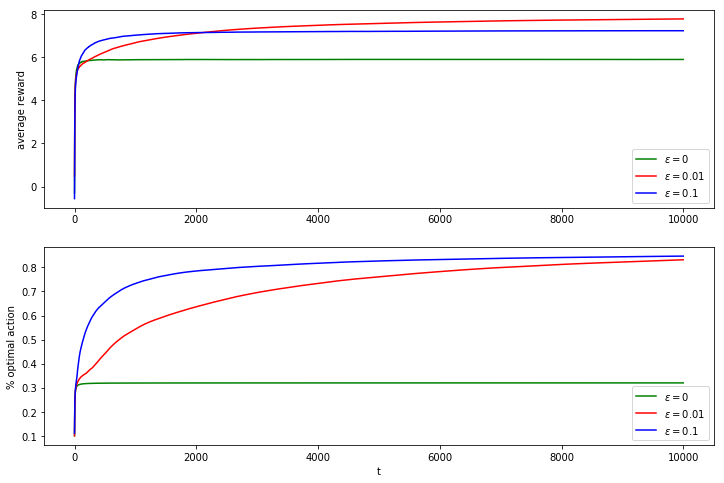

In [16]:
# Multiple comparison runs

reset_seed(42)

n_runs = 100
n_actions = 10
max_steps = 10000

agents = [EpsilonGreedyAgent(epsilon=0, n_actions=n_actions),     # epsilon = 0, full greed
          EpsilonGreedyAgent(epsilon=0.01, n_actions=n_actions),  # epsilon = 0.01, mostly greedy
          EpsilonGreedyAgent(epsilon=0.1, n_actions=n_actions)    # epsilon = 0.1, somewhat greedy
         ]

total_rewards = np.zeros(shape=(len(agents), max_steps))
total_optimal_actions = np.zeros(shape=(len(agents), max_steps))

for run in range(n_runs):
    print("\rRun {}".format(run + 1), end="")
    
    mu = [np.random.uniform(-10, 10) for _ in range(n_actions)]
    sigma = [np.random.uniform(0, 5) for _ in range(n_actions)]
    reward_distributions = [partial(np.random.normal, m, s) for m, s in zip(mu, sigma)]
    optimal_action = np.argmax(mu)

    env = ContinuousBandit(reward_distributions)
    
    for agent in agents:
        agent.reset_memory()

    for step in range(max_steps):
        for agent_index, agent in enumerate(agents):
            action = agent.epsilon_greedy()
            reward = env.step(action)
            agent.update_memory(action, reward)
            total_rewards[agent_index, step] += reward
            total_optimal_actions[agent_index, step] += (action == optimal_action)
            
for step in range(1, max_steps):
    for agent_index, _ in enumerate(agents):
        total_rewards[agent_index, step] += total_rewards[agent_index, step - 1]
        total_optimal_actions[agent_index, step] += total_optimal_actions[agent_index, step - 1]
            
average_rewards = total_rewards / (np.arange(max_steps) + 1) / n_runs
average_optimal_actions = total_optimal_actions / (np.arange(max_steps) + 1) / n_runs
    
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(np.arange(max_steps), average_rewards[0], 'g-', label=r"$\epsilon=0$")
plt.plot(np.arange(max_steps), average_rewards[1], 'r-', label=r"$\epsilon=0.01$")
plt.plot(np.arange(max_steps), average_rewards[2], 'b-', label=r"$\epsilon=0.1$")
plt.legend(loc="lower right")
plt.ylabel("average reward")

plt.subplot(2, 1, 2)
plt.plot(np.arange(max_steps), average_optimal_actions[0], 'g-', label=r"$\epsilon=0$")
plt.plot(np.arange(max_steps), average_optimal_actions[1], 'r-', label=r"$\epsilon=0.01$")
plt.plot(np.arange(max_steps), average_optimal_actions[2], 'b-', label=r"$\epsilon=0.1$")
plt.legend(loc="lower right")
plt.xlabel("t")
plt.ylabel("% optimal action")

plt.plot()

#### Interpretation

The greedy model (represented by the green curve) reached its peak quickly but then tapered off, meaning that it got stuck performing a suboptimal action. The epsilon-greedy policy with epsilon=0.1 (represented by the blue curve) found the optimal action earlier but only took it 91% of the time. The agent with epsilon=0.01 took some time finding the optimal action but would eventually perform better than the other two agents.

### Value

In every RL problems, the environment provides a quantitative reward whenever the agent takes an action. We name the expected reward of an action as the "value" of the action. In the example above, the agent computes the value of each action by adding up the total rewards obtained from that action divided by the number of times the action has been taken. This average reward will eventually converge to some number. There is another, equivalent way of computing the value in a k-armed bandit environment (the derivation of the formula is shown in the book).

In [17]:
reset_seed(42)

n_actions = 5

mu = [np.random.uniform(-10, 10) for _ in range(n_actions)]
sigma = [np.random.uniform(0, 5) for _ in range(n_actions)]
reward_distributions = [partial(np.random.normal, m, s) for m, s in zip(mu, sigma)]

values = [0 for _ in range(n_actions)]
n_tries = [0 for _ in range(n_actions)]
    
def epsilon_greedy(epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)  # random action
    else:
        return np.argmax(values)  # greedy action

env = ContinuousBandit(reward_distributions)

max_steps = 1000
epsilon = 0.1
total_reward = 0

for step in range(max_steps):
    a = epsilon_greedy(epsilon)
    reward = env.step(a)
    total_reward += reward
    n_tries[a] += 1
    values[a] = values[a] + 1/n_tries[a] * (reward - values[a])  # this is the important line
    
print("Total reward: %.2f" % total_reward)

Total reward: 8036.72


values[a] = values[a] + 1/n_tries[a] * (reward - values[a]) can be read as 

##### new_estimate = old_estimate + step_size * (actual_reward - old_estimate)

(reward - old_estimate) can be thought of as the "error" in the estimate, since the agent estimated the reward to be old_estimate but instead got actual_reward.

step_size in this case happens to be 1/n_tries[a] (obtained from the formula of average reward), but it can be something else for other policies. For example, when the reward distribution is nonstationary, it's impossible for  the values to converge, in which case it might be a better idea to use a constant step_size. Below is a non-stationary version of the k-armed bandit environment.

In [35]:
class MovingBandit():
    """
    A non-stationary bandit environment. The mean of the distribution of each action cam randomly shift 
    by some small amount.
    
    Args:
        mu: (list of scalars) the mean of the reward distribution of each action
        sigma: (list of scalars) the standard deviation of the reward distribution of each action
        shift_fn: (function) a function that takes no argument and returns a scalar, used to shift
            the reward distributions
    """
    def __init__(self, mu, sigma, shift_fn=partial(np.random.normal, 0, 0.1)):
        self.mu = mu
        self.sigma = sigma
        self.shift_fn = shift_fn
        
    def step(self, x):
        return np.random.normal(mu[x], sigma[x])
    
    def shift_rewards(self):
        # Randomly shift the reward distributions
        for i, _ in enumerate(self.mu):
            self.mu[i] += self.shift_fn()

In [34]:
class ValueAgent():
    """
    A class to represent an agent that stores value.
    
    Args:
        epsilon: (scalar) epsilon constant for the epsilon-greedy policy
        n_actions: (int) the number of possible actions
        step_size_fn: (function) a function that takes in an integer, the number of times this action has been
            taken, and returns a scalar, the value of step_size
    """
    def __init__(self, epsilon, n_actions, step_size_fn=lambda x: 0.1):
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.step_size_fn = step_size_fn
        self.reset_memory()
        
    def epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.values)
        
    def update_memory(self, action, reward):
        a = action
        self.n_tries[a] += 1
        self.values[a] = self.values[a] + self.step_size_fn(self.n_tries[a]) * (reward - self.values[a])
        
    def reset_memory(self):
        self.values = [0 for _ in range(self.n_actions)]
        self.n_tries = [0 for _ in range(self.n_actions)]

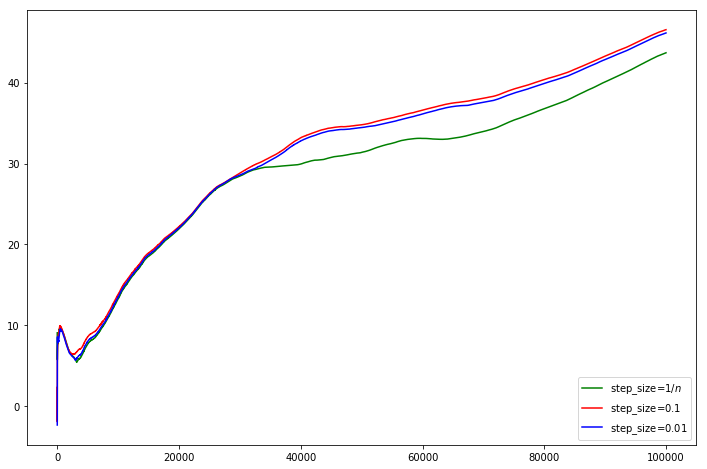

In [52]:
# Compare an agent that uses step_size = 1/n with an agent that uses a constant step_size

reset_seed(42)

n = 5

mu = [np.random.uniform(-10, 10) for _ in range(n)]
sigma = [np.random.uniform(0, 5) for _ in range(n)]
reward_distributions = [partial(np.random.normal, m, s) for m, s in zip(mu, sigma)]

env = MovingBandit(mu, sigma, shift_fn=partial(np.random.normal, 0, 0.1))

agents = [ValueAgent(epsilon=0.1, n_actions=n, step_size_fn=lambda x: 1/x),  # step_size = 1/n
          ValueAgent(epsilon=0.1, n_actions=n, step_size_fn=lambda x: 0.1),  # step_size = 0.1
          ValueAgent(epsilon=0.1, n_actions=n, step_size_fn=lambda x: 0.01)  # step_size = 0.01
         ]

total_rewards = [0 for _ in range(len(agents))]
average_rewards = [[] for _ in range(len(agents))]

max_steps = 100000

for step in range(max_steps):
    for agent_index, agent in enumerate(agents):
        action = agent.epsilon_greedy()
        reward = env.step(action)
        total_rewards[agent_index] += reward
        average_rewards[agent_index].append(total_rewards[agent_index] / (step + 1))
        agent.update_memory(action, reward)
        
    env.shift_rewards()
        
plt.figure(figsize=(12,8))   
plt.plot(np.arange(max_steps), average_rewards[0], 'g-', label=r"step_size=$1/n$")
plt.plot(np.arange(max_steps), average_rewards[1], 'r-', label=r"step_size=$0.1$")
plt.plot(np.arange(max_steps), average_rewards[2], 'b-', label=r"step_size=$0.01$")
plt.legend(loc="lower right")

In [31]:
np.random.normal(0, 0.1)

-0.0032793134447940513